In [1]:
%load_ext autoreload
%autoreload 2

## Package Imports & Setup 

In [2]:
# setting project path
import os
import sys

gparent = os.path.join(os.pardir, os.pardir)
sys.path.append(gparent)

# imports
import pandas as pd
import numpy as np

from sklearn.base import clone
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import make_column_selector
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline 
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import make_scorer, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline as make_sm_pipeline

import xgboost as xgb

from boruta import BorutaPy

from src import classes as c
from src import functions as f
from src import visualizations as v

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import plotly
# setting style
sns.set_theme('talk')
plt.style.use('fivethirtyeight')
sns.set_palette(palette='Blues_r')

# Terry Stops Project

**Author:** Jeffrey Hanif Watson
***

## Overview

This project's goal is to create and train a predictive model, based on a dataset of Seattle Terry Stops data, for use by legal assistance organizations, law firms, and district attorneys. Data cleaning, eda, modeling, tuning and evaluation were performed and a random forest classifier was chosen as the the final model for the project. Since we want to avoid both false positives and false negatives for this project, an accuracy measure of F1 was employed because it is sensitive to both types of error. Since F1 is a mix of both precision and recall, the interpretation of the results is more easily described in terms of recall and precision. An a final F1 accuracy score of 0.895318 was achieved at the end of the modeling process. Further a recall score of .92 meant that 92% of major outcomes were correctly classified as major outcomes, and a precision score of .87 indicated that 87% of stops classified as ending in a major outcome truly ended in a major outcome. An alternate logistic regression model  with an F1 accuracy score of 0.886699 (recall=.90, precision=.88) is also available for use by interested parties. Next steps for the project include implementing a feature selection algorithm, tuning an XGboost classifer, and further investigating the logistic regression model's adherence to the underlying assumption of logistic regression in an attempt to further quantify the effect of specific features on the model.

## Business Understanding
Individuals and entities, such as legal assistance organizations, law firms, and district attorneys, that need to allocate resources based on major interactions with the judicial system can benefit from a model that can predict such interactions based on Terry stop administrative and demographic data.

## Data Understanding
The initial data for the project was obtained as a .csv file of 47,213 rows and 23 (4 numeric and 19 categorical) feature columns of Terry Stops Data. After cleaning and feature engineering, the final data set contained 42,589 rows and 21 (9 numeric and 12 categorical) feature columns.

Originally, the model's target feature was created by dividing the `Stop Resolution` feature categories into two groups: No Arrest and Arrest. Upon moving through the modeling process, it was discovered that the structure of the data was not conducive to  predicting outcomes with the target formulated in this manner.

Ultimately, the target feature was re-formulated by grouping the `Stop Resolution` feature categories into two bins: Minor Outcomes (Field Contact, Citation/Infraction') and Major Outcomes (Arrest, Offense Report, Referred for Prosecution). This new target dramatically improved performance across all models.

Data set obtained from:
[data.gov](https://catalog.data.gov/dataset/terry-stops)

Original data columns explanations:
[data.seattle.gov](https://data.seattle.gov/Public-Safety/Terry-Stops/28ny-9ts8)

## Exploring the Stop Data (Highlights From the EDA)

Importing Data for EDA Visualizations

In [3]:
path = os.path.join(gparent, 'data/processed', 'report_eda_data.csv')
df = pd.read_csv(path, keep_default_na=False)

#### General Information

- 59% of Stops End in a Major Outcome
- 45% of Stops Originate from 911 Calls & 19% Are Initiated by Officer Observations. 
- 82.7% of 911 originated stops end in a major outcome.
- 66.6% of officer initiated stops end in a major outcome.
- 11.2% of stops with no origination information end in a major outcome.

#### Proportion of Terry Stops & Major Outcomes By Race

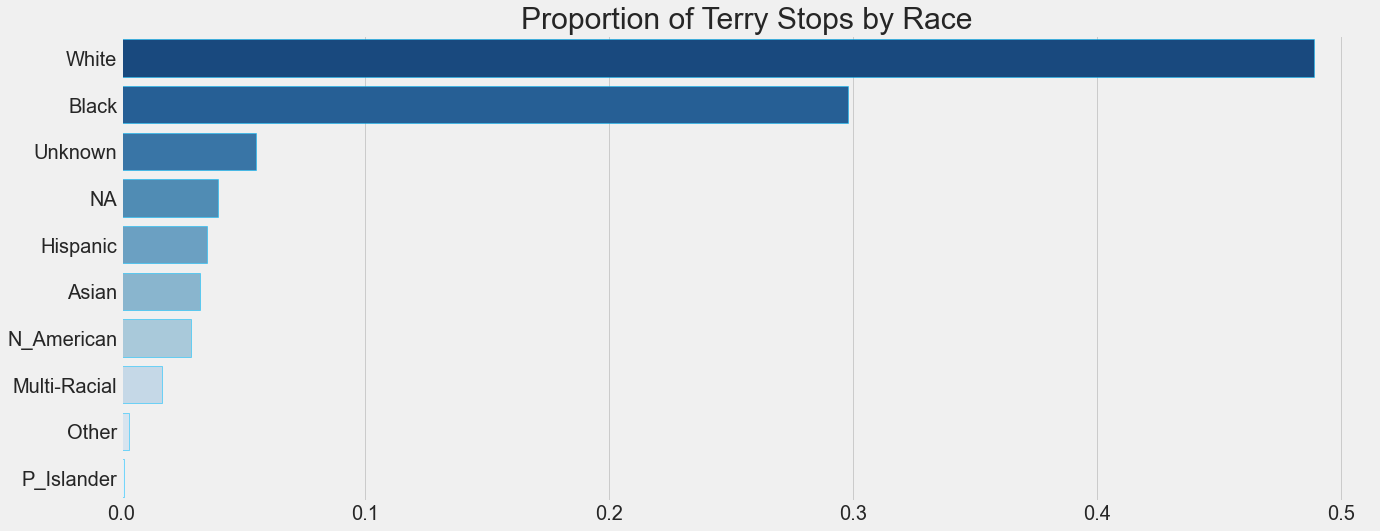

In [4]:
v.stops_by_race(df)

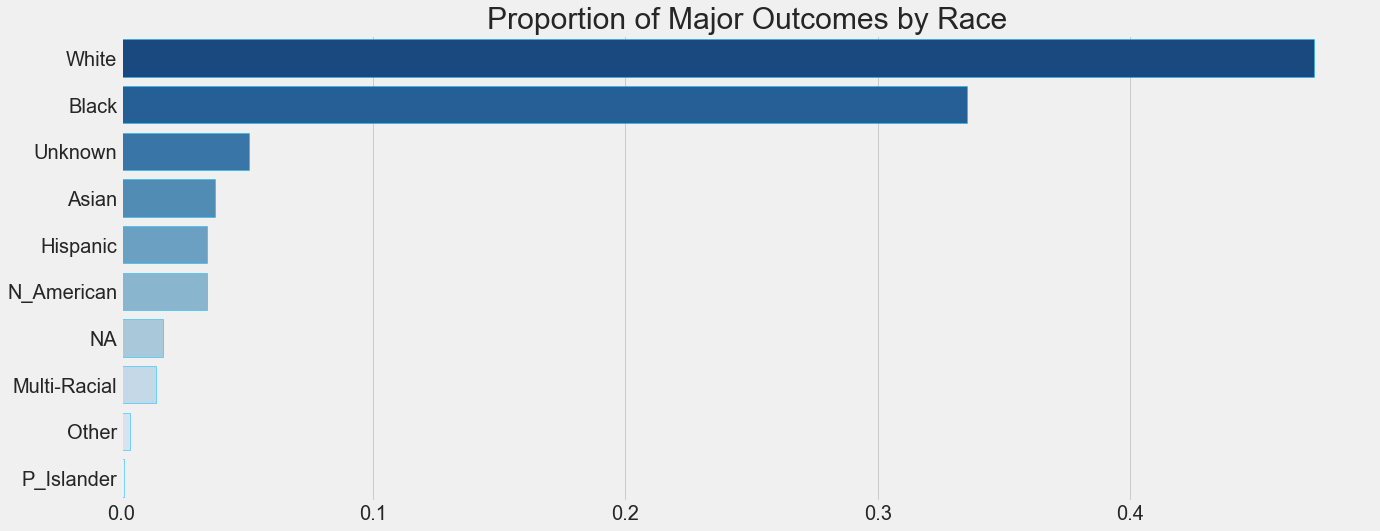

In [5]:
v.outcome_by_race(df)

#### Disproportionate Outcomes for Certain Racial Groups
When we compare the proportion of stops and major outcomes to the proportion of each racial group in the population, we can see that there are the amount of Terry stops and major outcomes (Arrest, Offense Report, Referred for Prosecution) are disproportionate for certain groups.

**According to July 1, 2019 US Census Data for Seattle and the calculations above:**

- **Asian**: 15.4% of population, 3.2% of stops, 3.2% of major outcomes.

- **White**: (Non-Hispanic) 63.8% of population, 48.9% of stops, 48.3% of major outcomes.

- **Black**: 7.3% of population, 29.9% of stops, 32.1% of major outcomes.

- **Native American**: 0.5% of population, 2.9% of stops, 3.1% of major outcomes.

- **Hispanic**: 6.7% of population, 3.5% of stops, 3.8% of major outcomes.

- **Multi-Racial**: 6.9% of population, 1.7% of stops, 1.8% of major outcomes.

- **Pacific Islander**: 0.3% of population, .12% of stops, .11% of major outcomes.

The Unknown racial category is absent from the census data but makes up 5.6% of stops and 5.1% of major outcomes.

#### Weapon Found Rate By Race

Checking to see if the disparate rate of stops and major outcomes is justified by an increased likelihood of finding a weapon on certain groups.

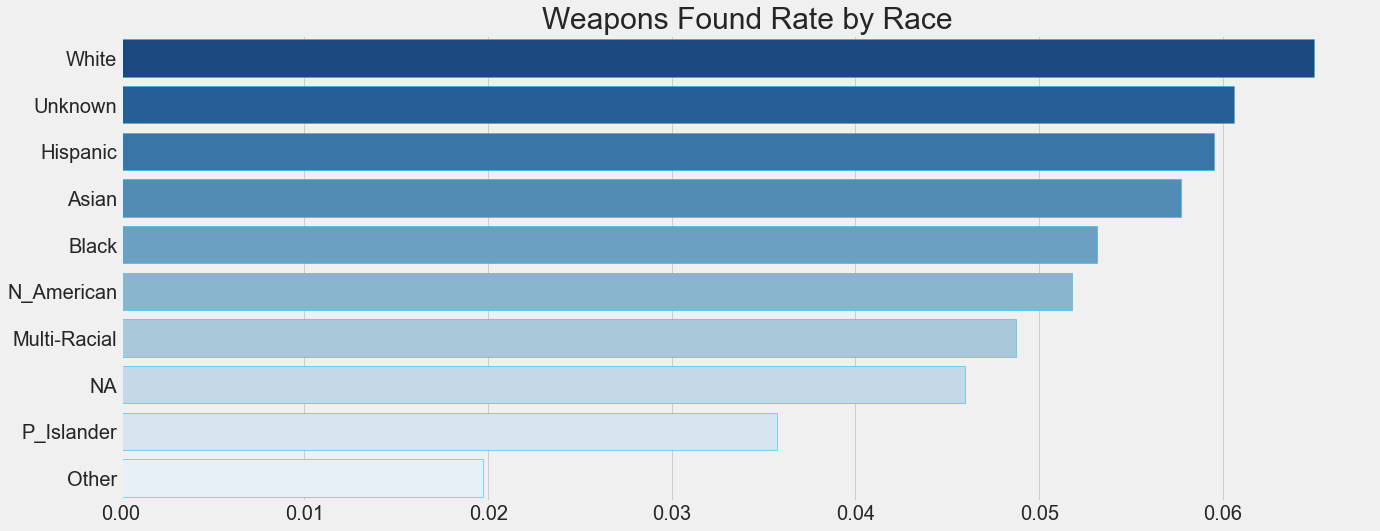

[['White', 0.06496448956472485],
 ['Unknown', 0.06060606060606061],
 ['Hispanic', 0.059495192307692304],
 ['Asian', 0.05774278215223097],
 ['Black', 0.0531283518055059],
 ['N_American', 0.05181347150259067],
 ['Multi-Racial', 0.04875],
 ['NA', 0.045989304812834225],
 ['P_Islander', 0.03571428571428571],
 ['Other', 0.019736842105263157]]

In [6]:
v.weapons_rate(df)

From the visualization and calculation above, it appears that White, Hispanic, and Asian subjects are stopped less frequently than suggested by the weapon found rate. Conversly, Black subjects are stopped elevated rates relative to the weapon found rate.

#### Certain Missing Administrative Data is Correlated with Minor Outcomes

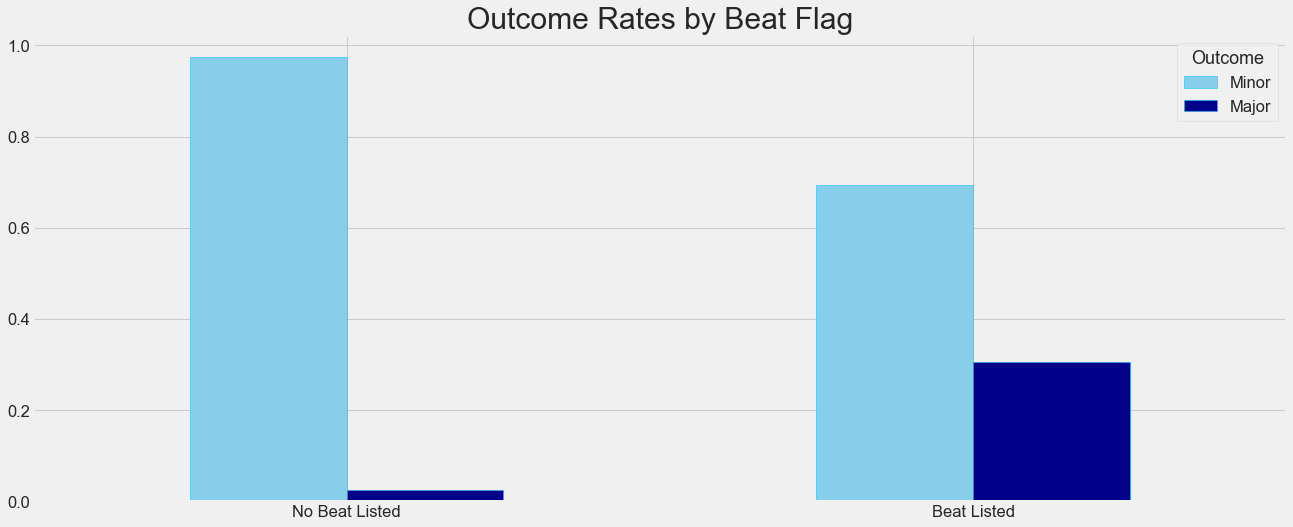

In [7]:
v.outcome_by_beat(df)

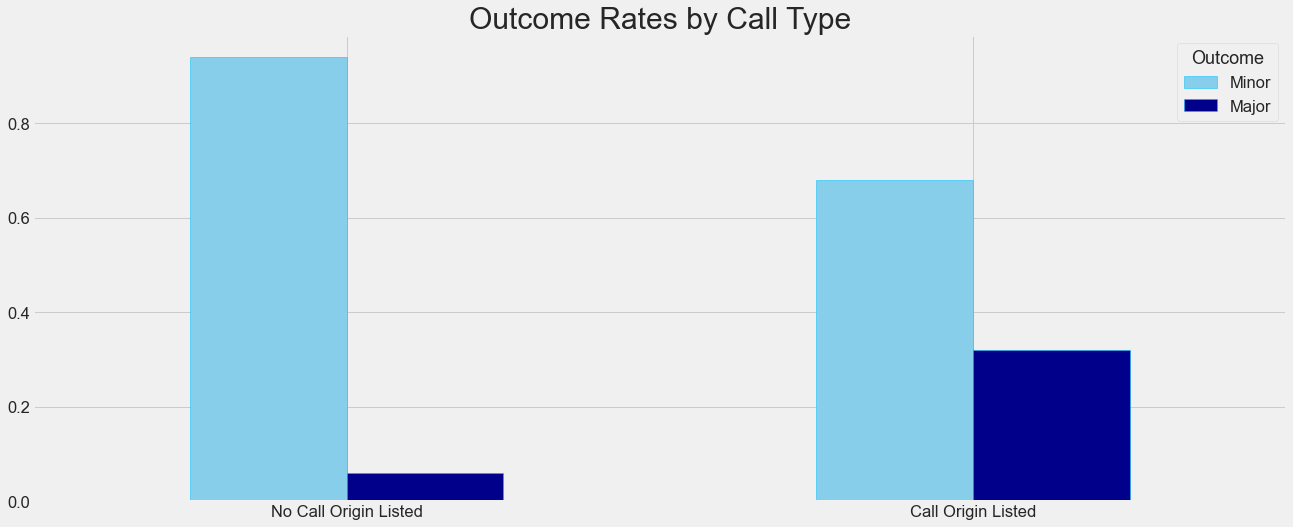

In [8]:
v.outcome_by_call(df)

- Calls With No Origination Information (28% of calls) Are Much Less Likely to End in a Major Outcome

- Stops With No Beat Information (21% of Stops) Are Much Less Likely to End in A Major Outcome

- Stops With No Precinct Information (21% of Stops) Also Have Much Lower Major Outcome Rates

#### NA values in the Administrative Data Figure Heavily in the Final Model

## Data Preparation
Light data cleaning was performed to reformat certain strings and rename some categories for convenience. Nulls and placeholder values were replaced by the string `NA`. Call Time And Date features were converted to datetime objects and split. No rows were dropped during the data preparation process.

## Modeling

#### Importing the Data

In [9]:
path = os.path.join(gparent, 'data/processed', 'report_baseline_data.csv')
df = pd.read_csv(path, keep_default_na=False)

#### Preprocessing and Harness Objects
Column selectors a preprocessing transformer with one-hot encoding and min-max scaling, and an F1 scoring object were created for use in the modeling pipelines. A modeling harness was also instantiated to cross validate, record, and display the modeling results.

In [10]:
string_selector = make_column_selector(dtype_include='object')
number_selector = make_column_selector(dtype_include='number', dtype_exclude='object')

preprocessing_mm = make_column_transformer((OneHotEncoder
                                         (handle_unknown='ignore'),string_selector),
                                          (MinMaxScaler(), number_selector))

In [11]:
# creating f1 scorer
f1 = f.f1

In [12]:
modeling = c.Harness(f1)

#### Baseline Data Frame Info
Based on the EDA, an initial data frame was created with the columns detailed below. 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 46960 entries, 0 to 46959
Data columns (total 12 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Target                    46960 non-null  int64 
 1   Subject Age Group         46960 non-null  object
 2   Weapon Type               46960 non-null  object
 3   Officer YOB               46960 non-null  int64 
 4   Officer Gender            46960 non-null  object
 5   Officer Race              46960 non-null  object
 6   Subject Perceived Race    46960 non-null  object
 7   Subject Perceived Gender  46960 non-null  object
 8   Initial Call Type         46960 non-null  object
 9   Call Type                 46960 non-null  object
 10  Officer Squad             46960 non-null  object
 11  Precinct                  46960 non-null  object
dtypes: int64(2), object(10)
memory usage: 4.3+ MB


#### Creating X, y & Train Test Split

In [14]:
X, y = f.Xy(df)

In [15]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

### Baseline Logistic Regression

#### Creating Pipeline

In [16]:
# adding a random state for a future solver gridsearch 
LR = LogisticRegression(max_iter=1000, n_jobs=-1, random_state = 2021)

In [17]:
baseline = make_pipeline(preprocessing_mm, LR)

#### Fitting & Scoring Model

In [18]:
baseline.fit(X_train, y_train);

In [19]:
#scoring the model
f1_score(y_train, baseline.predict(X_train))

0.884196120994762

In [20]:
# checking cross val scores
modeling.report(baseline, X_train, y_train, 'Baseline Logistic Regression', 'Log Reg, min/max scaled')

Baseline Logistic Regression has an average F1 of 0.8810525054191466


array([0.88269208, 0.88256816, 0.88164422, 0.88122696, 0.8771311 ])

#### Scoring the Model on Test Data

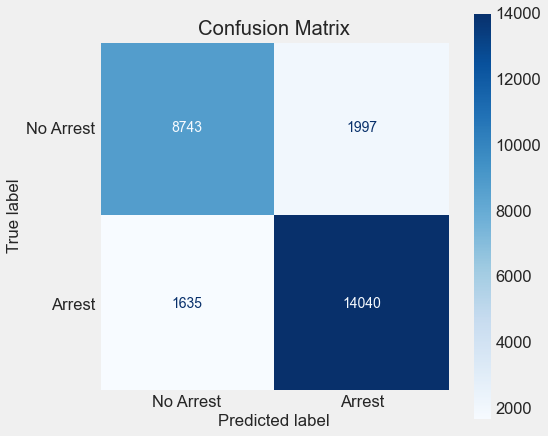

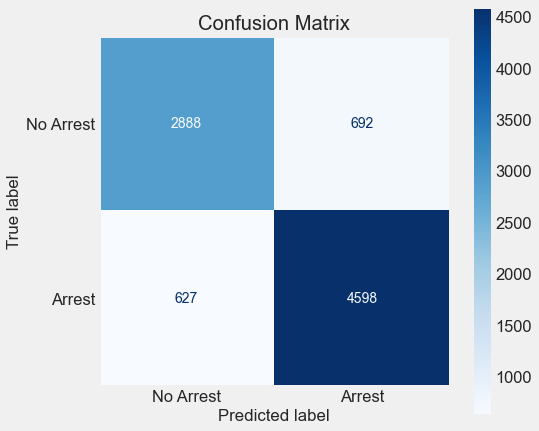

,Train F1,Test F1,Test Recall,Test Precision
0,0.885469,0.87456,0.88,0.869187


In [23]:
f.subsplit_test(X_train, y_train, baseline)

### Baseline Score: F1 = 0.87456

#### Score Interpretation
Since we want to avoid both false positives and false negatives for this project, an accuracy measure of F1 was employed because it is sensitive to both types of error. Also, because F1 is a mix of both precision and recall, the interpretation of the results is more easily described in terms of recall and precision. 

- A recall score of .88 means that 88% of major outcomes were correctly classified as major outcomes. 
- A precision score of .87 indicates that 87% of stops classified as ending in a major outcome truly ended in a major outcome.

#### Baseline Coefficients & Odds

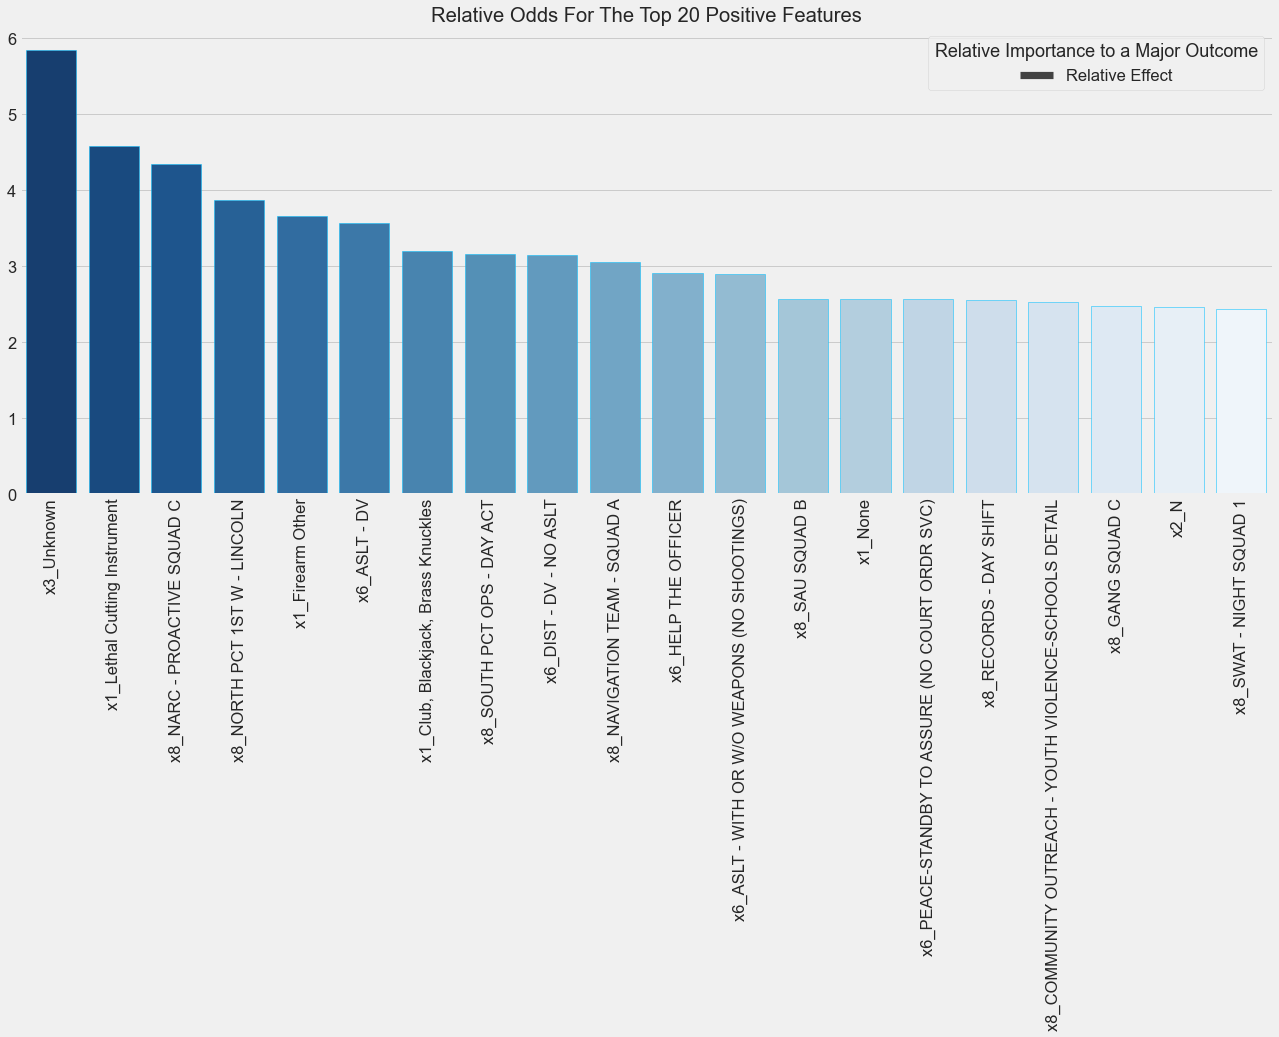

In [24]:
v.positive_odds(baseline, X_train)

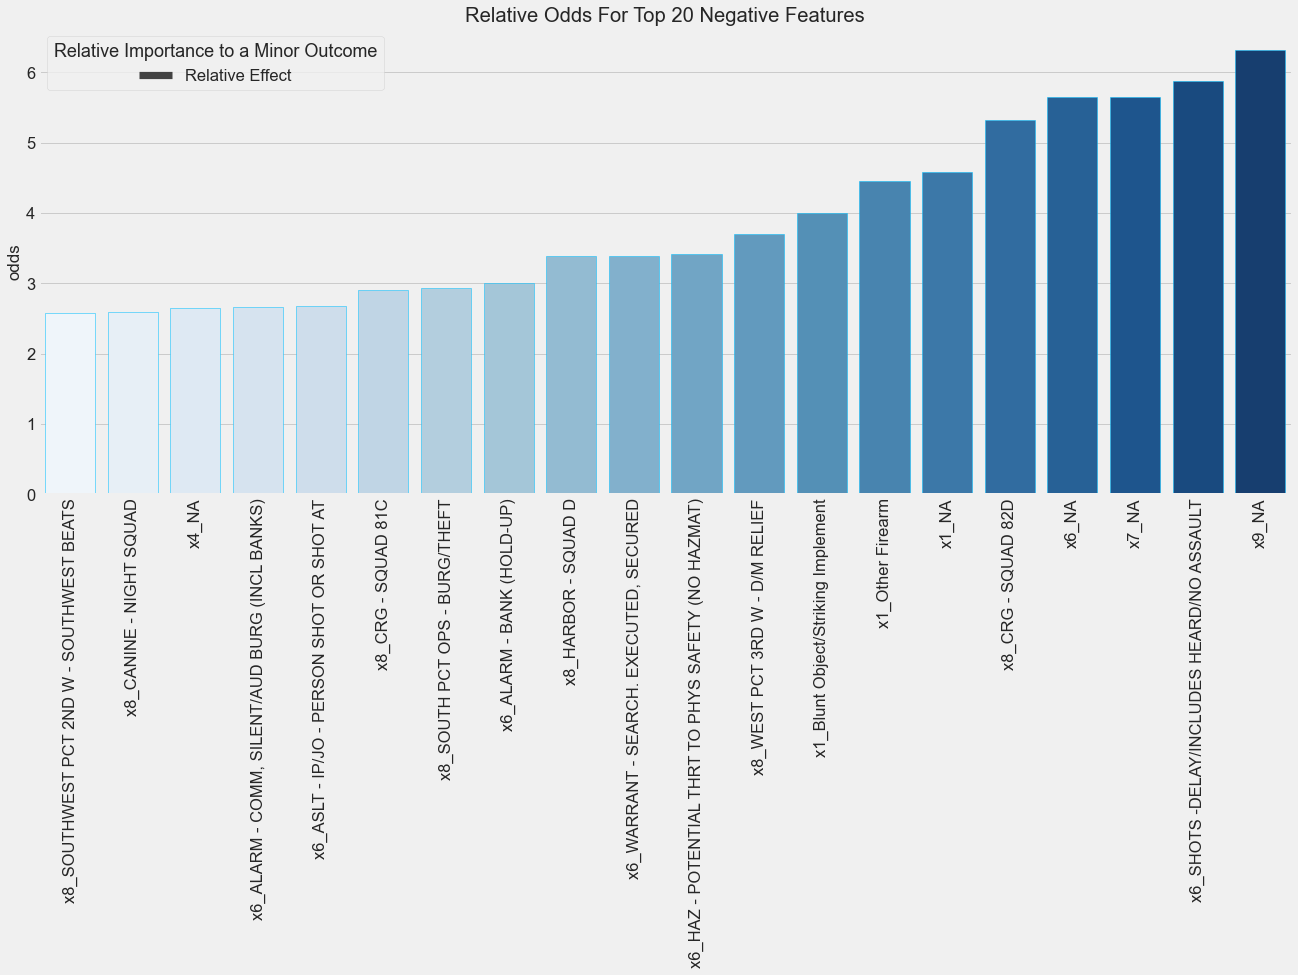

In [25]:
v.negative_odds(baseline, X_train)

#### Interpretation of the Odds
If the assumptions of logistic regression were met by the model, we could numerically quantify the effect of each feature on the model. However, since it is beyond the scope of the project to check that the model meets the underlying assumptions of logistic regression, the most we can say about the features above are their relative importances to the model. A higher bar means more importance of the feature to the model. 

### Feature Engineering & Intermediate Models

After a baseline data frame and model were established, additional features were added and/or engineered and tested one by one. Feature engineering techniques included binarizing, binning, and creating new features by combining two base features. For example, an `Officer Age` feature was created by combining the `Officer YOB` (Year of Birth) column with the `Reported Year` Column. After a first round of features were added, models were tuned and tested on different combinations of the new data and a random forest classifier was found to have the greatest F1 accuracy. A second round of feature engineering was undertaken to try and wring a little more accuracy from the models. For example,  a simplified `Weapon Bins` was created from the `Weapon Type` column by binning the major weapon types into separate bins and grouping the minor weapon types into a single `Other` category. The models were again tested and tuned on the new data, and the results are presented below.

### Final Models

#### Creating Final Dataframe

In [26]:
path = os.path.join(gparent, 'data/processed', 'report_final_data.csv')
df = pd.read_csv(path, keep_default_na=False)

#### Final Data Info
The final data set contained 42,589 rows and 21 (9 numeric and 12 categorical) feature columns.

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42589 entries, 0 to 42588
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Target                    42589 non-null  int64  
 1   Subject Age Group         42589 non-null  object 
 2   Weapon Type               42589 non-null  object 
 3   Officer Gender            42589 non-null  object 
 4   Officer Race              42589 non-null  object 
 5   Subject Perceived Race    42589 non-null  int64  
 6   Subject Perceived Gender  42589 non-null  int64  
 7   Initial Call Type         42589 non-null  object 
 8   Call Type                 42589 non-null  object 
 9   Officer Squad             42589 non-null  object 
 10  Precinct                  42589 non-null  object 
 11  Beat Flag                 42589 non-null  int64  
 12  Officer Age               42589 non-null  float64
 13  Racial Affinity           42589 non-null  int64  
 14  Gender

#### Creating X, y & Train Test Split

In [28]:
X, y = f.Xy(df)

In [29]:
X_train, X_test, y_train, y_test = f.splitter(X,y)

### Final Logistic Regression Classifier

#### Pipeline

In [30]:
LR_ALL_tuned = LogisticRegression(C=2.6366508987303554,
                            solver='lbfgs', penalty='l2',
                              class_weight=None,
                            max_iter=1000, n_jobs=-1)

pipeline  = make_pipeline(preprocessing_mm, LR_ALL_tuned)

#### Fitting & Scoring the Model

In [31]:
pipeline.fit(X_train, y_train)
f1_score(y_train, pipeline.predict(X_train))

0.8902355882130142

In [32]:
modeling.report(pipeline, X_train, y_train, 'Final Logistic Regression',\
                'penalty=l2, solver=lbfgs, C=2.6366508987303554, \
                class_weight=None')

Final Logistic Regression has an average F1 of 0.8872832847319995


array([0.8926639 , 0.88779129, 0.88737374, 0.88332914, 0.88525836])

In [33]:
modeling.history

,Name,Accuracy (F1),Notes
0,Baseline Logistic Regression,0.881053,"Log Reg, min/max scaled"
1,Final Logistic Regression,0.887283,"penalty=l2, solver=lbfgs, C=2.6366508987303554..."


#### Scoring the Model on Test Data

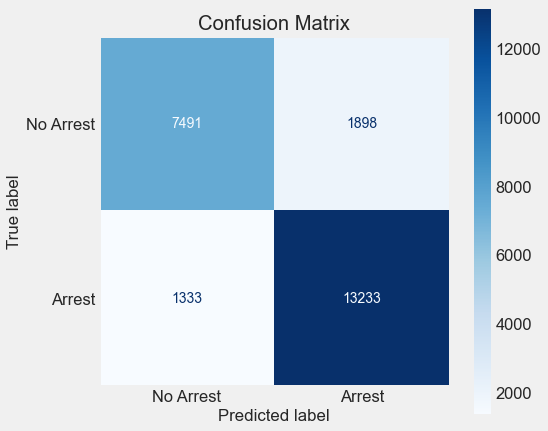

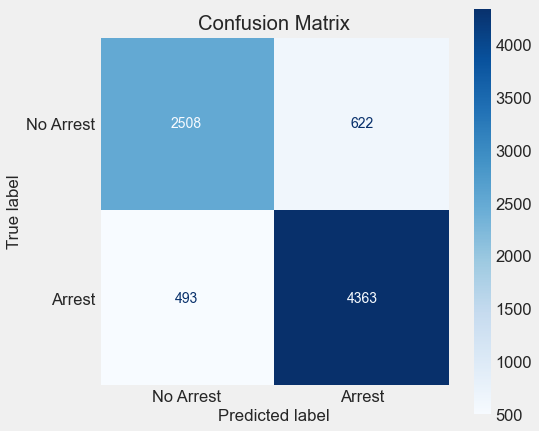

,Train F1,Test F1,Test Recall,Test Precision
0,0.891201,0.886699,0.898476,0.875226


In [34]:
f.subsplit_test(X_train, y_train, pipeline)

### Final Logistic Regression Score: F1=0.886699

- A recall score of .90 means that 90% of major outcomes were correctly classified as major outcomes. 
- A precision score of .88 indicates that 88% of stops classified as ending in a major outcome truly ended in a major outcome.

#### Coefficients & Odds

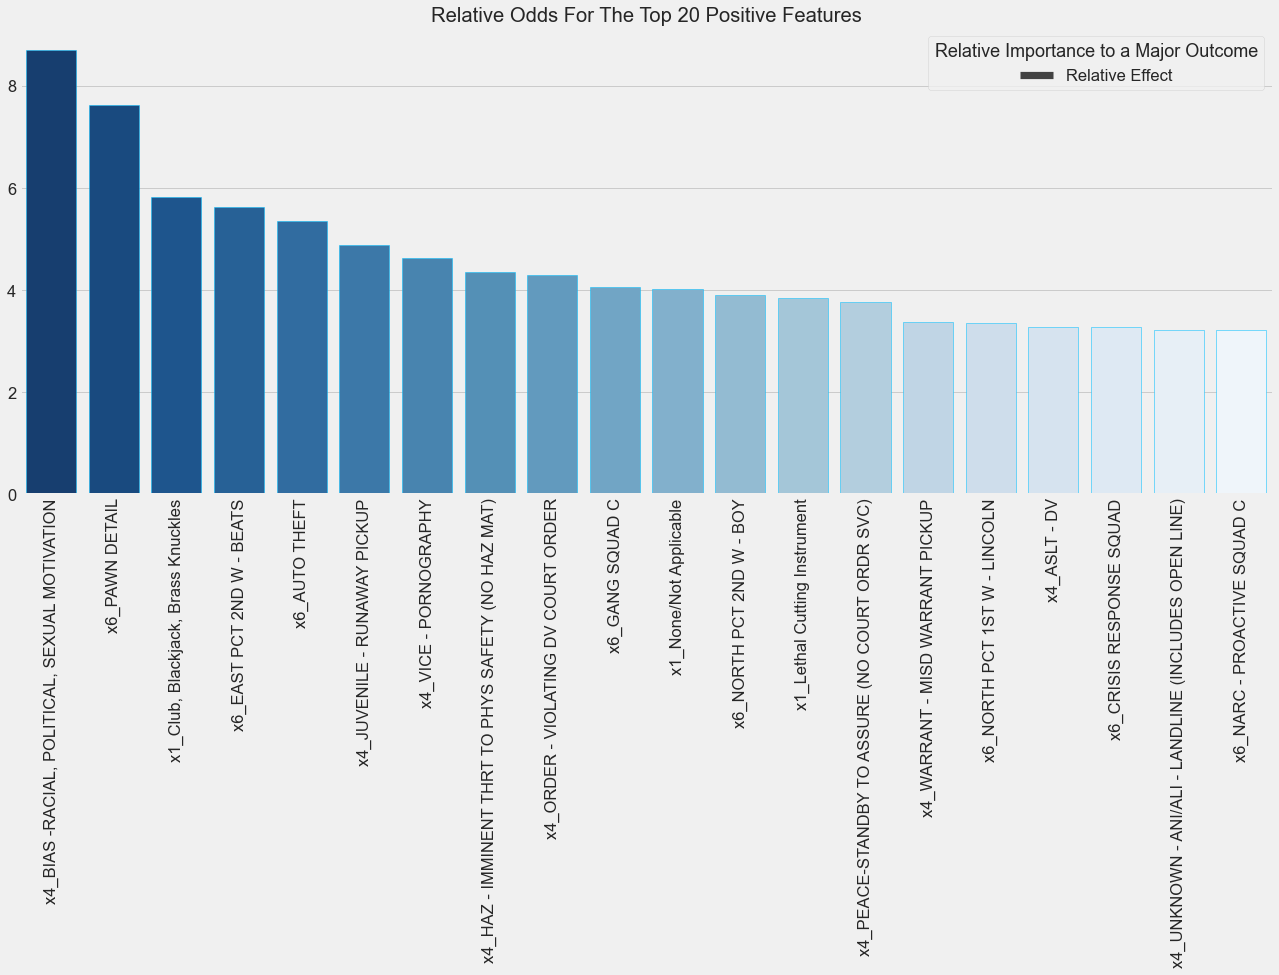

In [35]:
v.positive_odds(pipeline, X_train)

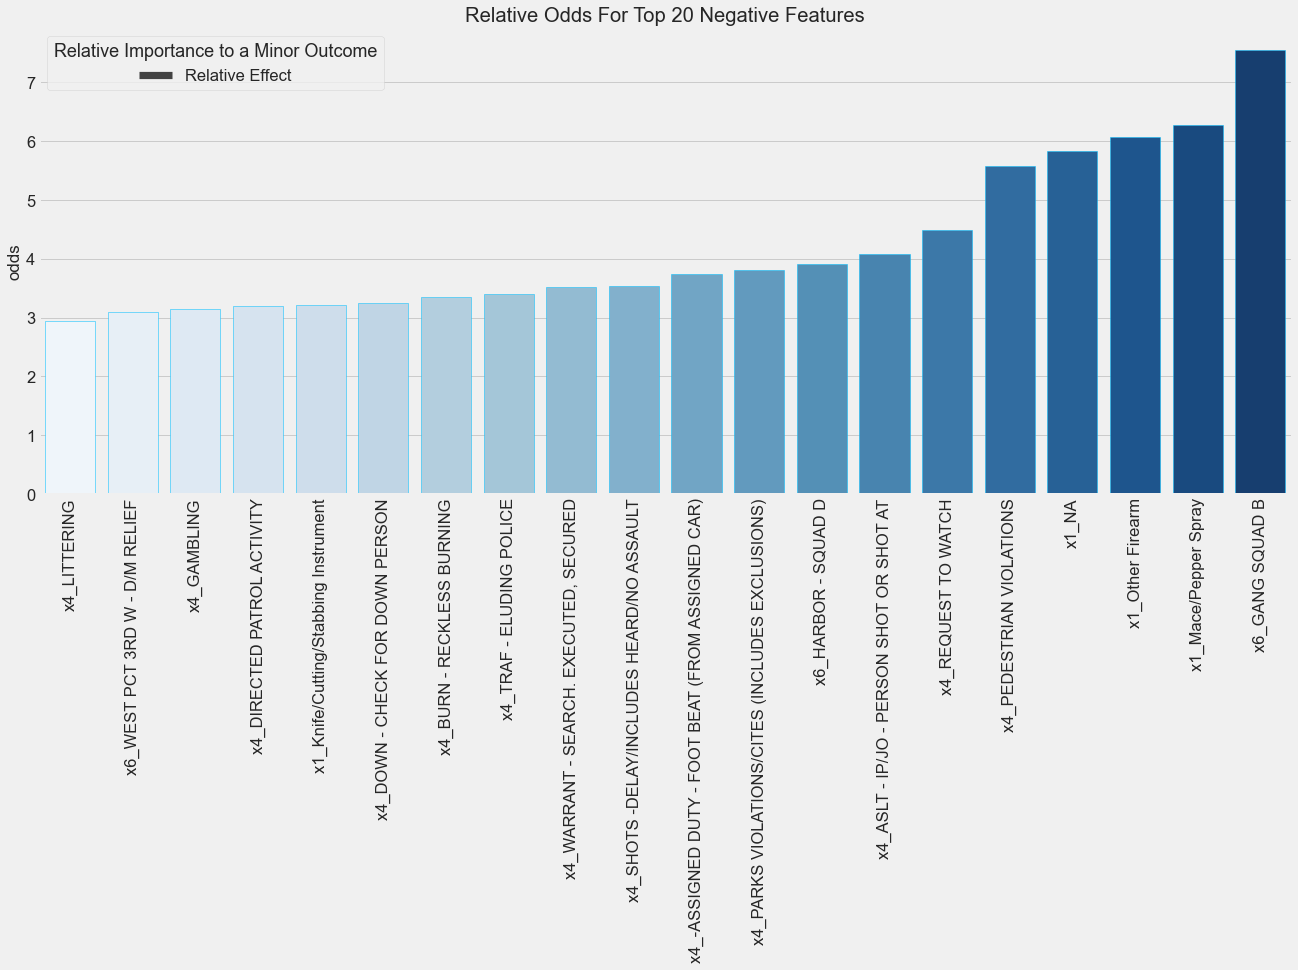

In [36]:
v.negative_odds(pipeline, X_train)

#### Relevant Features and Interpretation of Odds
`Weapon Type` (x1), `Initial Call Type` (x4), and `Officer Squad` (x6) are the only base feature columns that are driving the final logistic regression model. 

Again, if the assumptions of logistic regression were met by the model, we could numerically quantify the effect of each feature on the model. However, with the visualization above, we can point to the relative importances of the features: a higher the bar means more importance of the feature to the model.

### Final Random Forest Classifier

#### Pipeline

In [37]:
RF_ALL = RandomForestClassifier(criterion='gini',
                             max_depth=None,
                             min_samples_split=10,
                                max_features='auto',
                                min_samples_leaf=1,
                                n_jobs=-1,
                                n_estimators=100,
                            random_state=2021)

rfall_pipeline = make_pipeline(preprocessing_mm, RF_ALL)

#### Fitting and Scoring

In [38]:
rfall_pipeline.fit(X_train, y_train);

f1_score(y_train, rfall_pipeline.predict(X_train))

0.9467497414423732

In [39]:
modeling.report(rfall_pipeline, X_train, y_train, 'Final Random Forest', 'criterion=gini,\
                                                            max_depth=None,\
                                                            min_samples_split=10,\
                                                            class_weight=None,\
                                                            min_samples_leaf=1,\
                                                            max_features=auto,\
                                                            n_estimators=100')

Final Random Forest has an average F1 of 0.8968056186879323


array([0.90352412, 0.89542157, 0.89651729, 0.89455359, 0.89401153])

In [40]:
modeling.history

,Name,Accuracy (F1),Notes
0,Baseline Logistic Regression,0.881053,"Log Reg, min/max scaled"
1,Final Logistic Regression,0.887283,"penalty=l2, solver=lbfgs, C=2.6366508987303554..."
2,Final Random Forest,0.896806,"criterion=gini, ..."


#### Testing on Subsplits

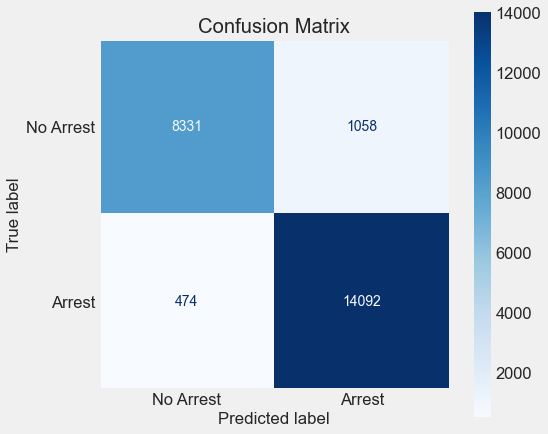

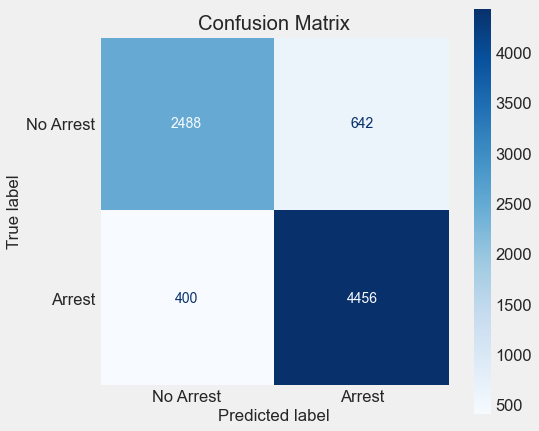

,Train F1,Test F1,Test Recall,Test Precision
0,0.948445,0.895318,0.917628,0.874068


In [41]:
f.subsplit_test( X_train, y_train, rfall_pipeline)

### Final Random Forest Score: F1=0.895318

- A recall score of .92 means that 92% of major outcomes were correctly classified as major outcomes.
- A precision score of .87 indicates that 87% of stops classified as ending in a major outcome truly ended in a major outcome.

#### Feature Importances

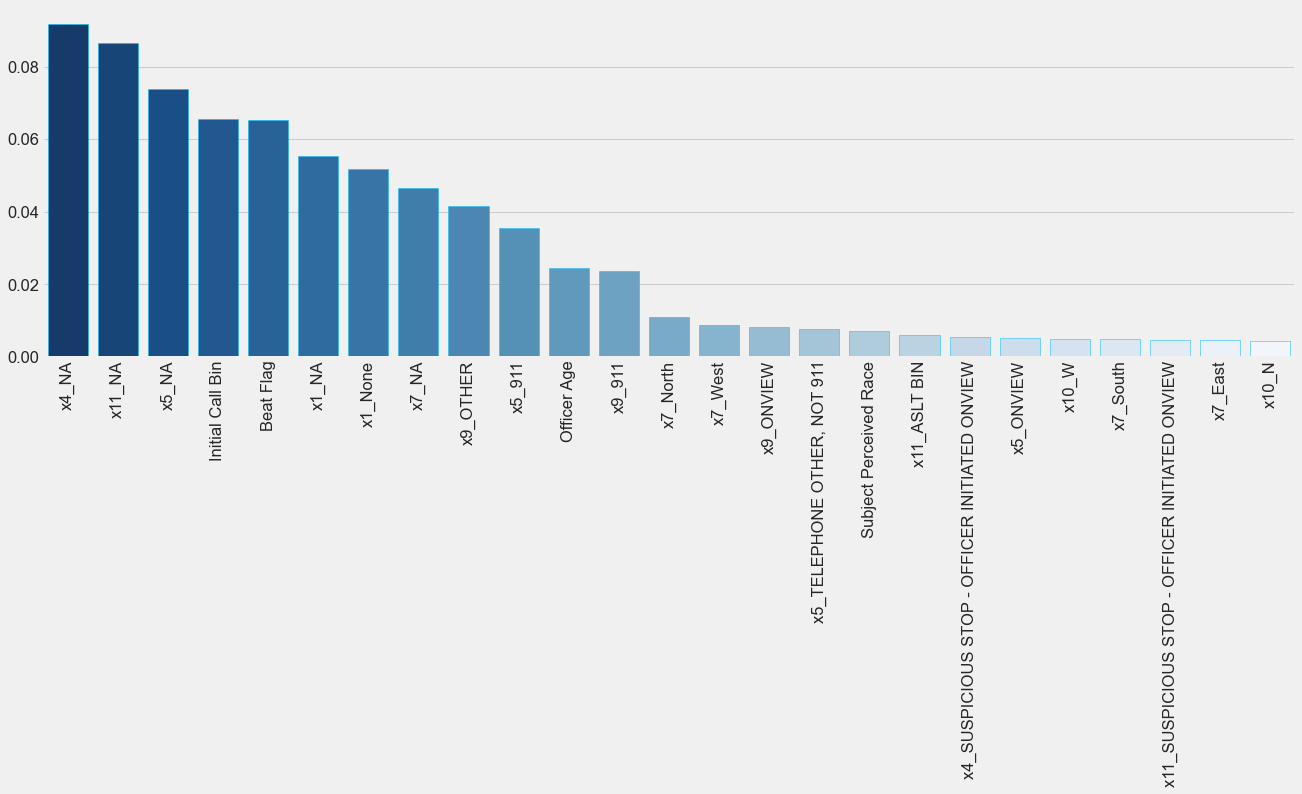

In [42]:
v.importance_plot(rfall_pipeline, X_train)

As noted in the EDA section of the report, data categories of `NA` are the most important factor driving the final model. Of the first 10 features (ranked in terms of importance to the model), only 2 (`Weapon Type` = `x1_None` & `Call Type`= `x5_911`) do not involve data categories of `NA`. Even the `Call Type Bins` = `x9_OTHER` category is made up of a majority of `NA` values. Interestingly, the only two demographic categories that are present in the top features are `Officer Age` and `Subject Preceived Race`.

In [43]:
features = list(rfall_pipeline[0].transformers_[0][1].get_feature_names()) +\
                list(X_train.select_dtypes('number').columns)

## Conclusion

## Next Steps

Next steps for the project include:
- Implementing a feature selection algorithm. 
- Tuning an XGboost classifer. 
- Further investigating the logistic regression model's adherence to the underlying assumption of logistic regression in an attempt to further quantify the effect of specific features on the model.